# beit Transfer Learning
### [microsoft/beit-base-patch16-224-pt22k-ft22k](https://huggingface.co/microsoft/beit-base-patch16-224-pt22k-ft22k)
### Importación de librerías

In [1]:
from transformers import BeitImageProcessor, BeitForImageClassification, BeitFeatureExtractor, default_data_collator
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

2023-03-20 11:30:23.506838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 11:30:24.136134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-03-20 11:30:24.136190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-03-20 11:30:24.136194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38

### Imagen de prueba

In [2]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

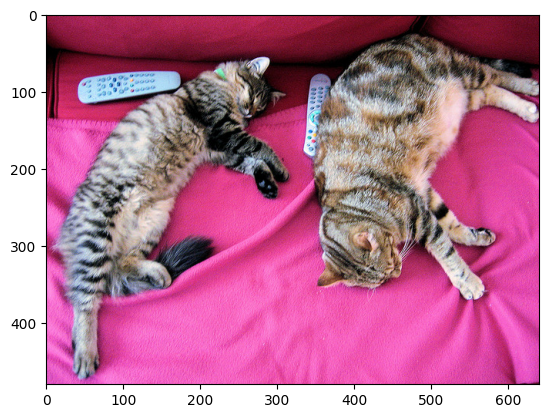

In [3]:
# show the image
plt.imshow(image)

### Prueba del modelo

In [4]:
processor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

In [5]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: tabby, tabby_cat


---
### id2labels

In [6]:
id2label = {0: 'Burger', 1: 'Fried Chicken', 2: 'Donut', 3: 'French Fries', 4: 'Hot Dog', 5: 'Pizza', 6: 'Sandwiches', 7: 'Rost Potatoes'}

---
### Transfer learning - Att. 1

In [7]:
import math
import matplotlib.pyplot as plt
import shutil
#from getpass import getpass
from PIL import Image
# from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import BeitImageProcessor, BeitForImageClassification, BeitFeatureExtractor, default_data_collator

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_re

Transform current data to desired format

In [9]:
import pandas as pd
# load train and test dataset
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
# join train and test dataset
df = pd.concat([train_df, test_df], axis=0)
# drop idx_train and idx_test columns
df.drop(["idx_train", "idx_test"], axis=1, inplace=True)

In [10]:
id2label = {0: 'Burger', 1: 'Fried Chicken', 2: 'Donut', 3: 'French Fries', 4: 'Hot Dog', 5: 'Pizza', 6: 'Sandwiches', 7: 'Rost Potatoes'}

In [11]:
# replace labels with id2label
df["label"] = df["label"].apply(lambda x: id2label[x])

In [12]:
df.groupby("label").count()

,path_img
label,
Burger,2000
Donut,2000
French Fries,2000
Fried Chicken,2000
Hot Dog,2000
Pizza,2000
Rost Potatoes,2000
Sandwiches,2000


In [ ]:
# create a folder for each label in the path "images/all_imgs/treated"
for label in df["label"].unique():
    Path(f"images/treated/{label}").mkdir(parents=True, exist_ok=True)

In [16]:
df.iloc[2]["path_img"]

'images/51df0f29-758b-4741-ab74-a0ff8e21c044.jpeg'

In [18]:
# save each image in a folder with its label
not_found = []

for i in range(len(df)):
    img_path = df.iloc[i]["path_img"]
    label = df.iloc[i]["label"]
    filename = img_path.split("/")[-1]
    try:
        shutil.copy(img_path, f"images/treated/{label}/{filename}")
    except FileNotFoundError:
        not_found.append(img_path)

In [19]:
print('Files not found:', len(not_found))
# show files not found in the dataset
df[df["path_img"].isin(not_found)]

Files not found: 0


,path_img,label


Done transforming data

In [13]:
data_dir = Path("images/treated")
data_dir

PosixPath('images/treated')

In [14]:
# initialize dataset and split it into train and validation
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(ds) * 0.2)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

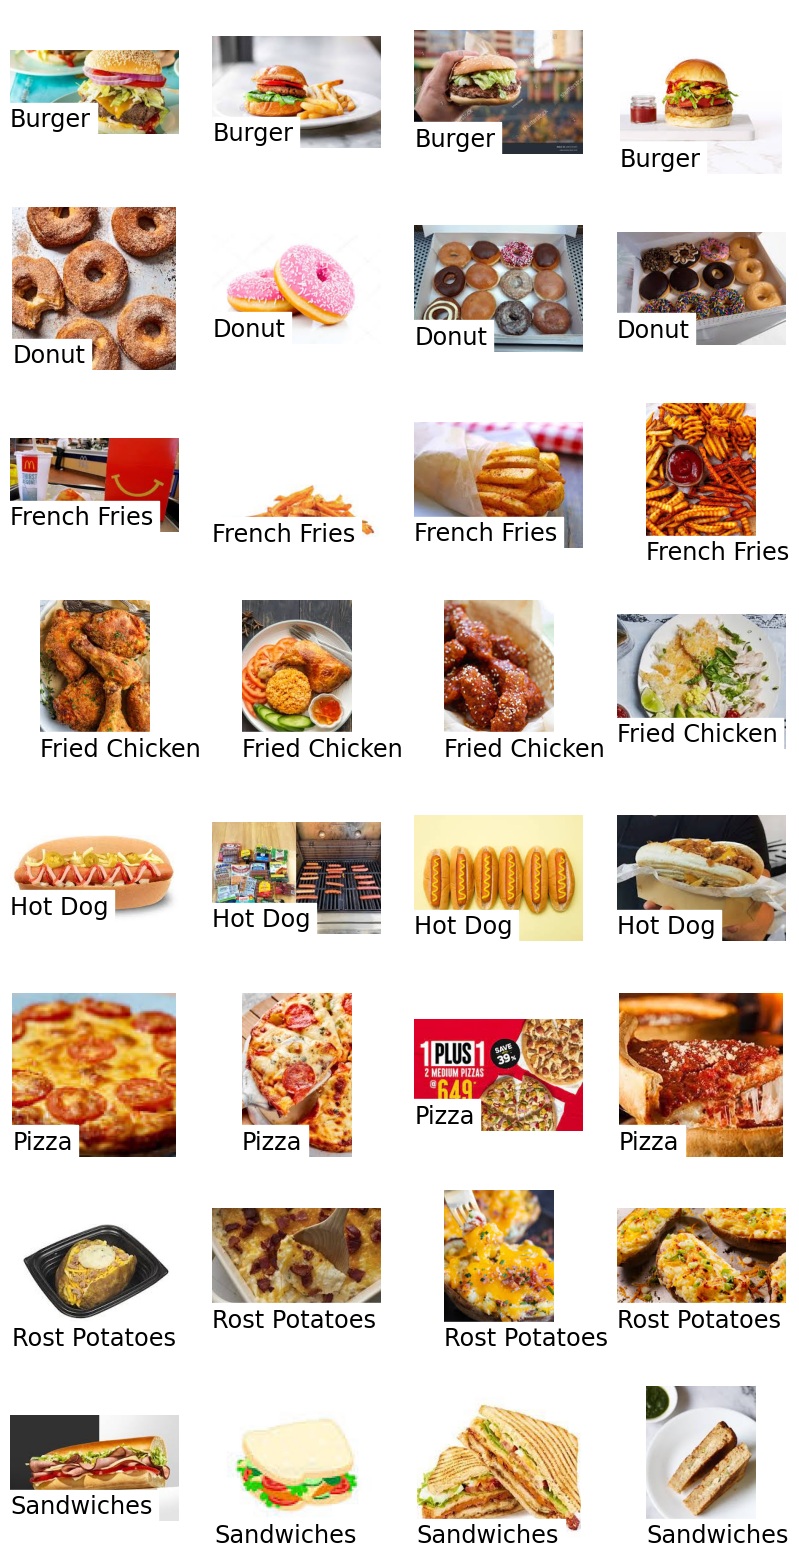

In [15]:
# Show some images
plt.figure(figsize=(10,20))
num_examples_per_class = 4
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [16]:
# preparing labels
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [17]:
# image classification collator
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [18]:
id2label

{'0': 'Burger',
 '1': 'Donut',
 '2': 'French Fries',
 '3': 'Fried Chicken',
 '4': 'Hot Dog',
 '5': 'Pizza',
 '6': 'Rost Potatoes',
 '7': 'Sandwiches'}

In [19]:
# Initialize feature extractor, model and data loaders
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model = BeitForImageClassification.from_pretrained(
    'microsoft/beit-base-patch16-224-pt22k-ft22k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator)

/home/22021108Cristina/.local/lib/python3.10/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Training
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [21]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='auto', devices=1, precision=16, max_epochs=4)

Global seed set to 42
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/22021108Cristina/.local/lib/python3.10/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
H

In [22]:
trainer.fit(classifier, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | model   | BeitForImageClassification | 85.8 M
1 | val_acc | MulticlassAccuracy         | 0     
-------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.073   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/22021108Cristina/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/22021108Cristina/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/22021108Cristina/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [23]:
# check the results
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([0, 0, 0, 7, 7, 6, 3, 5])
Labels: tensor([0, 0, 0, 7, 7, 6, 3, 5])


Test/evaluate the model

In [24]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [25]:
# get predictions
preds = []
labels = []

for batch in val_loader:
    print(f'Batch {len(preds) + 1}/{len(val_loader)}', end='\r')
    outputs = model(**batch)
    preds.append(outputs.logits.softmax(1).argmax(1))
    labels.append(batch['labels'])

In [26]:
preds = torch.cat(preds)
labels = torch.cat(labels)

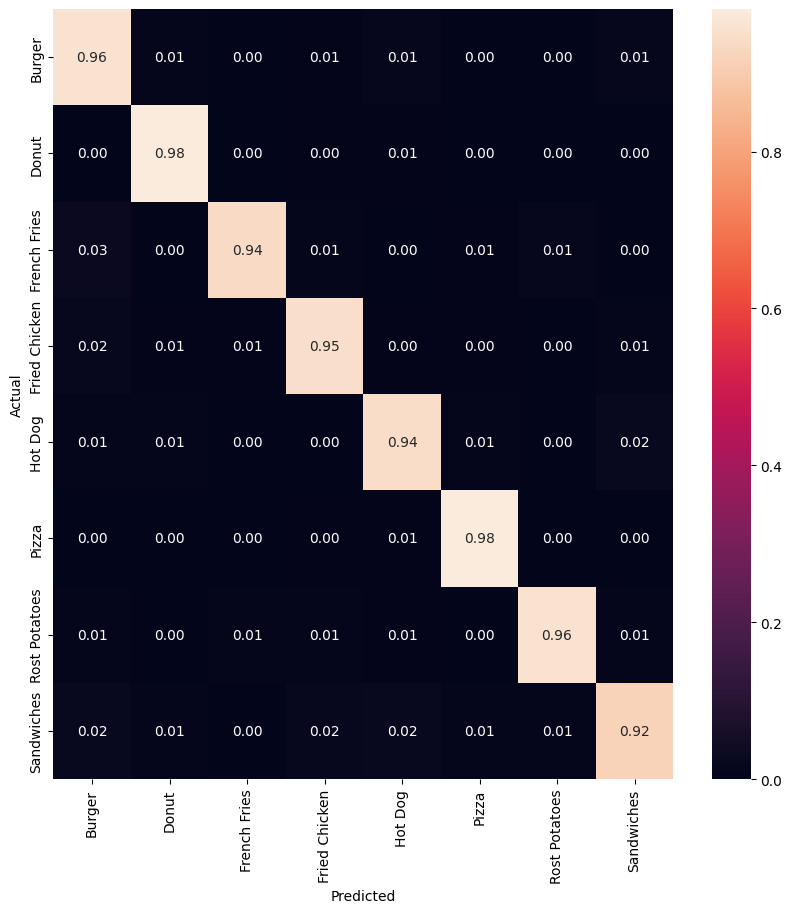

In [27]:
# create confusion matrix
cm = confusion_matrix(labels, preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=ds.classes, yticklabels=ds.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
# f1 score
from sklearn.metrics import f1_score

f1_score(labels, preds, average='weighted')

0.9540665159237122

In [34]:
import json
# transform index and preds to list
preds_list = preds.tolist()
val_ds_indices = val_ds.indices
# create a dict where preds_list is the value and val_ds_indices is the key
preds_json = dict(zip(val_ds_indices, preds_list))
# export preds_json to json file called predictions.json
with open('predictions.json', 'w') as f:
    json.dump(preds_json, f)